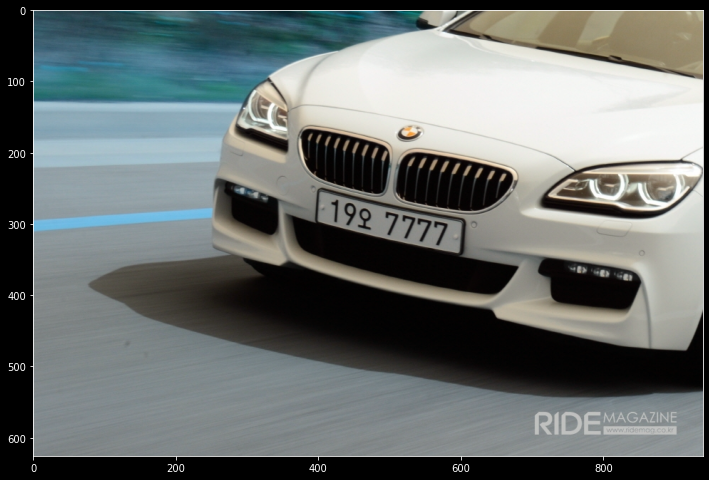

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')


img_ori = cv2.imread('1.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img_ori, cmap='gray')

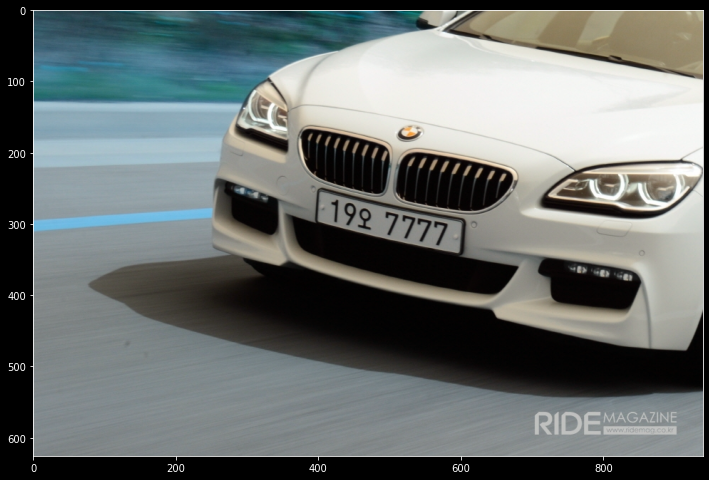

In [2]:
# gray scale 로 변환
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(img_ori, cmap='gray')

# adaptive thresholding

In [3]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX = 0) # 이미지의 노이즈를 제거하기 위함

# adaptive thresholding: 픽셀값들의 분포중에서 어느 특정 값에 임계값을 주어 극단적으로 나눔. 예를들어 100중 50을 임계점으로 둔다면, 
# 50아래로 모두 0으로, 50위는 모두 100으로 
img_thresh = cv2.adaptiveThreshold(
img_blurred,
maxValue = 255.0,
adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
thresholdType = cv2.THRESH_BINARY_INV,
blockSize = 19,
C = 9)

# find contours

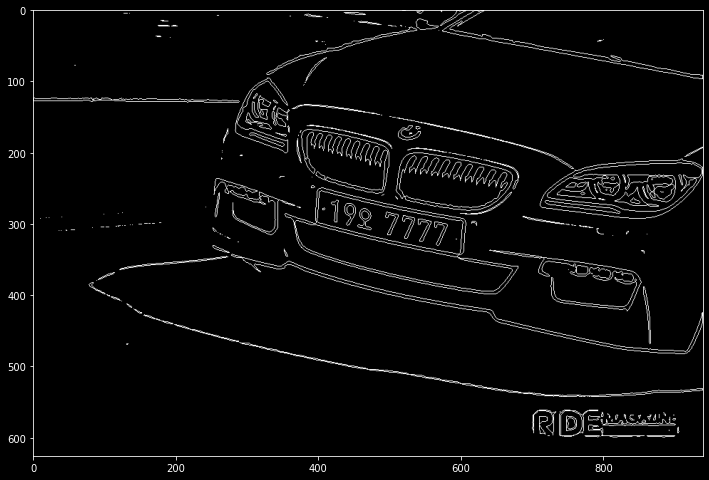

In [8]:
# 윤곽선을 찾음
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# 윤곽선 그림, contourIdx = -1 -> 전체 contour를 그리겠다는 의미입니다.
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12,10))
plt.imshow(temp_result)

# prepare data

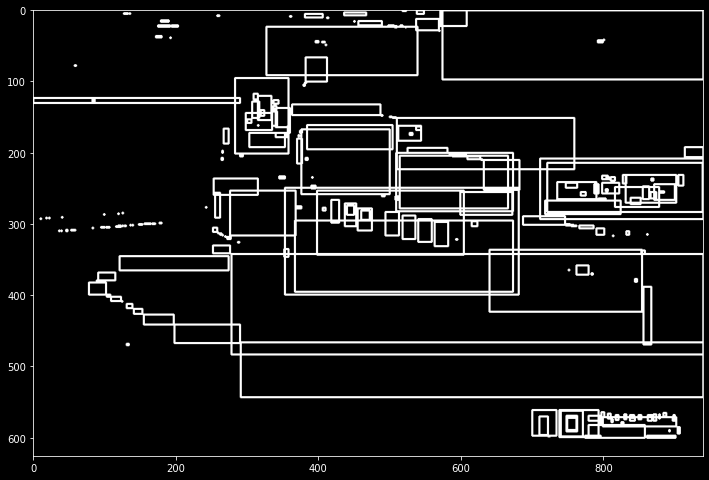

In [9]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict=[]

# 윤곽선을 감싸는 사각형을 구합니다. 
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour) #사각형의 범위를 찾습니다
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w,y+h), color=(255,255,255),thickness=2) # 사각형을 그립니다.
    
    contours_dict.append({
        'contour':contour,
        'x':x,
        'y':y,
        'w':w,
        'h':h,
        'cx':x+(w/2), # 중심좌표
        'cy':y+(h/2) # 중심좌표
    })
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

# select candidates by char size : 어떤게 번호판 처럼 생겼는지 판별

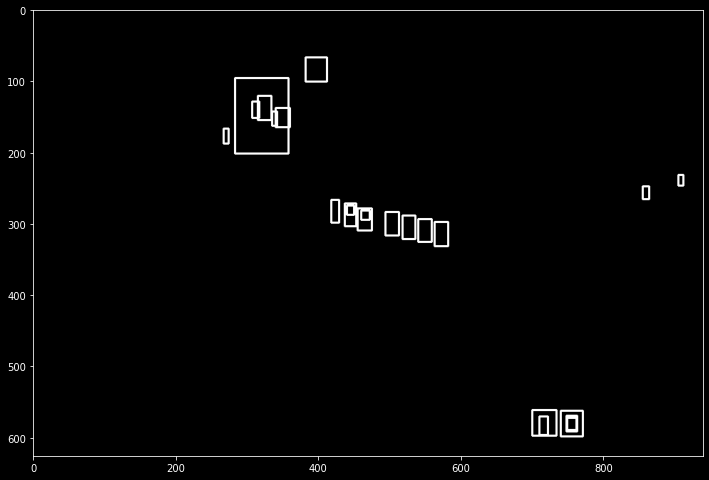

In [10]:
# 번호판의 있는 숫자들과 글자들은 어느 특정 비율로 그려져 있는데 그 비율(크기)를 지정해서 판별

MIN_AREA = 80 # 바운딩 박스의 최소 넓이
MIN_WIDTH, MIN_HEIGHT = 2, 8 # 최소 너비, 높이 
MIN_RATIO, MAX_RATIO = 0.25, 1.0 # 가로세로의 비율의 최소, 최대

possible_contours = []

# 위에서 뽑은 전체 바운딩 박스들의 넓이와 비율을 구한다.
cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    # 구해진 넓이와 비율이 우리가 사전에 정의한 숫자와 같다면 possible contours에 저장
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt #나중에 인덱스로 연산을 하기 때문에 인덱스를 추가로 만들어줌.
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

# select candidates by arragnement of contours: 번호판의 가능성이 있는 바운딩 박스중 나열된 모양을 보고 구별해서 진짜 번호판을 추려냄

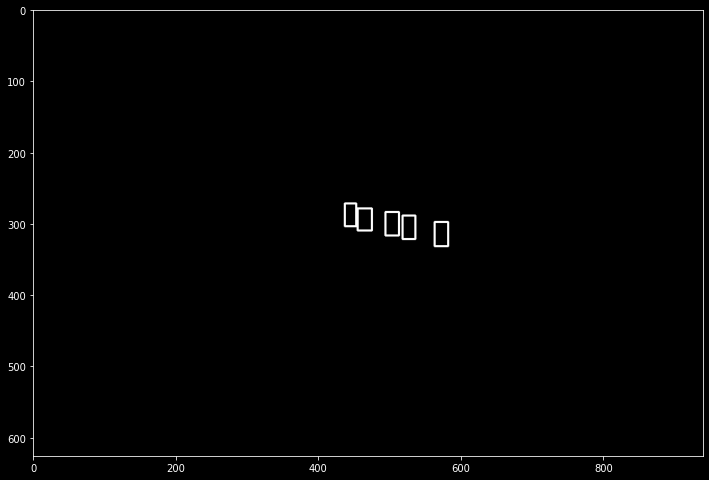

In [12]:
#리얼 번호판 추려내기 (모든 바운딩 박스간의 길이는 바운딩 박스의 중심에서 중심으로 게산이 됩니다.)
MAX_DIAG_MULTIPLYER = 5 # 두 바운딩 박스 간의 사이의 거리를 제한합니다. 이는 첫번째 바운딩 박스의 대각선의 길이 보다 5배 이내에 있어야 함
MAX_ANGLE_DIFF = 12.0 # 두 바운딩 박스간의 거리를 그렸을때의 θ값의 최대값
MAX_AREA_DIFF = 0.5 # 두 바운딩 박스간의 면적의 차이의 최대값
MAX_WIDTH_DIFF = 0.8 # 두 바운딩 박스간의 너비의 차이의 최대값
MAX_HEIGHT_DIFF = 0.2 # 두 바운딩 박스간의 높이의 차이의 최대값
MIN_N_MATCHED = 3 # 3 # 위 조건들을 만족하는 바운딩 박스들이 최소 3개는 있어야 번호판으로 인정을 한다는 뜻

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']: # 비교할 두개의 바운딩 박스가 같다면 continue
                
                continue

            dx = abs(d1['cx'] - d2['cx']) # 두 바운딩 박스간의 길이 차이 (x축)
            dy = abs(d1['cy'] - d2['cy']) # 두 바운딩 박스간의 길이 차이 (y축)

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # 각각의 바운딩 박스의 대각선의 길이

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])) # 두 바운딩박스간의 거리
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # tanθ = dy/dx 이므로, θ = arctan dy/dx. '도'의 결과로 받고 싶기 때문에 degrees사용
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            #우리가 설정한 기준에 맞는 바운딩 박스들만 matched_contours_idx에 넣어줌 (인덱스만 넣어줌)
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx']) #지금까지 비교하던 2개의 바운딩 박스중 비교대상이던 d2만 리스트에 넣었으므로, d1도 리스트에 넣어줌

        if len(matched_contours_idx) < MIN_N_MATCHED: # 번호판 후보들이 3개 미만이면 번호판일가능성이 적음
            continue

        matched_result_idx.append(matched_contours_idx)
        
        #후보에 들지 못햇던 바운딩 박스들을 한번더 고려해줌
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        # np.take(a,idx) -> a에서 idx와 같은 인덱스의 값만 추출
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

# rotate plate images : affine transform 

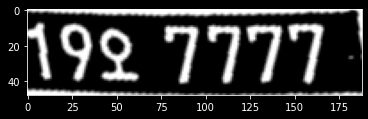

In [14]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx']) # 순서가 뒤죽박죽일수도 있으므로 x를 기준으로 sort
    
    # plate라고 생각되는 바운딩 박스들의 중심을 구함
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    # 너비 구함
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
    
    # 높이 구함
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # 연속된 바운딩박스들의 중심부를 연결해서 직각삼각형을 그리고 arcsin을 이용해서 θ값을 구함
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    #rotation matrix를 구함
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    #구해진 matirx를 warpaffine을 통해서 이미지를 회전
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    # 회전된 이미지에서 번호판 부분만 잘라냄
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
plt.imshow(img_cropped, cmap='gray')

# another thresholding

In [ ]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.show()
© 2021 GitHub, Inc.
Terms
Privacy
Securit